# BTC ML/DL Trading strategy

In [1]:
# Enabling the notebook execution from this sub-folder
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [2]:
# Importin utils global variables and methods
from src.Utils import *
from src.Backtesting import *
from src.Strategies import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

<div style="background:red; color:white; padding: 6px 8px">
    <h3 style="border-bottom: 2px solid white">WARNING</h3>
    <p>Please delete all the previously computed model during fitting phase.</p>
</div>

In [3]:
# Removing old model files
files = glob.glob("../out/models/model_*")
for f in files:
    os.remove(f)
print("Removing model files from previous fitting steps")

Removing model files from previous fitting steps


## Preliminary data import & handling

In [4]:
# Importing Bitcoin pre-processed financial data
df = pq.read_pandas(source=f"{Utils.ASSETS_FOLDER}/parquet/{Utils.get_asset_id('Bitcoin')}.parquet").to_pandas()

In [5]:
# Deepcopying the dataset
df_ = df.copy(deep=True)

**Reference**:
1. https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [6]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
2018-01-01 00:02:00,235,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
2018-01-01 00:03:00,528,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
2018-01-01 00:04:00,435,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
2018-01-01 00:05:00,742,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


In [7]:
# Displaying column informations
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2136278 entries, 2018-01-01 00:01:00 to 2022-01-24 00:00:00
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Count   int32  
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  float64
 6   VWAP    float64
dtypes: float64(6), int32(1)
memory usage: 122.2 MB


In [8]:
# Resampling to 20-min bins (or 10-min)
df = df.resample("30T").agg({
    "Count": "median",
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "mean",
    "VWAP": "mean"
})

# Removing NaN and broadcasting it to `Count`
df["Count"] = pd.to_numeric(arg=df["Count"], downcast="integer")
df.fillna(method="bfill", inplace=True)

# Deepcopying the dataset
df_sampled = df.copy(deep=True)

In [9]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:00:00,332.0,13835.194,14052.3,13400.01,13648.280,54.279809,13679.133461
2018-01-01 00:30:00,251.5,13638.620,13999.9,13450.00,13646.514,44.616116,13648.028607
2018-01-01 01:00:00,207.0,13632.890,13885.5,13402.28,13611.250,28.137192,13609.351165
2018-01-01 01:30:00,295.5,13643.916,13789.1,13155.38,13336.952,68.063402,13487.292515
2018-01-01 02:00:00,275.0,13337.022,13600.0,13202.03,13348.502,44.384983,13408.135192


In [10]:
# Some statistical analysis
df.describe().style.background_gradient(cmap="summer")

,Count,Open,High,Low,Close,Volume,VWAP
count,71233.000000,71233.000000,71233.000000,71233.000000,71233.000000,71233.000000,71233.000000
mean,996.204428,18707.024417,18815.597574,18596.575063,18707.325887,89.570700,18707.069624
std,1152.716294,17864.000418,17938.370706,17775.043143,17863.983659,100.466727,17863.727316
min,1.000000,3157.225714,3235.400000,3120.000000,3160.405000,0.006581,3164.302401
25%,316.500000,7125.195714,7168.000000,7085.810000,7125.191429,39.442043,7124.063847
50%,603.500000,9503.865714,9541.510000,9460.750000,9503.767143,61.068501,9504.024359
75%,1283.000000,32229.405000,32449.000000,31989.740000,32229.886250,101.216898,32219.544849
max,37009.000000,68609.590000,69024.200000,68400.000000,68619.115000,3095.249560,68582.325659


## Data visualization

In [11]:
# TODO (check Kaggle)

## Data aggregation

We are encouraged to add:
- additional metrics (RSI, moving averages, ...) and indicators from technical analysis
- additional data sources (from historical data API including FTX or Binance APIs)
- use of resampling routine to:
    - identify patterns
    - reduce the length of our data sample

### Log-returns & Day-time range

In [12]:
# Adding the daytime range for each line
try:
    df_t = [obs.hour for obs in list(df.index)]
    df["TimeRange"] = [Utils.get_daytime_range(time_) for time_ in df_t]
except KeyError:
    pass

In [13]:
# Computing log-returns
df["LogReturns"] = np.log(df["Close"]).diff()
df["LogReturns"].fillna(0, inplace=True)

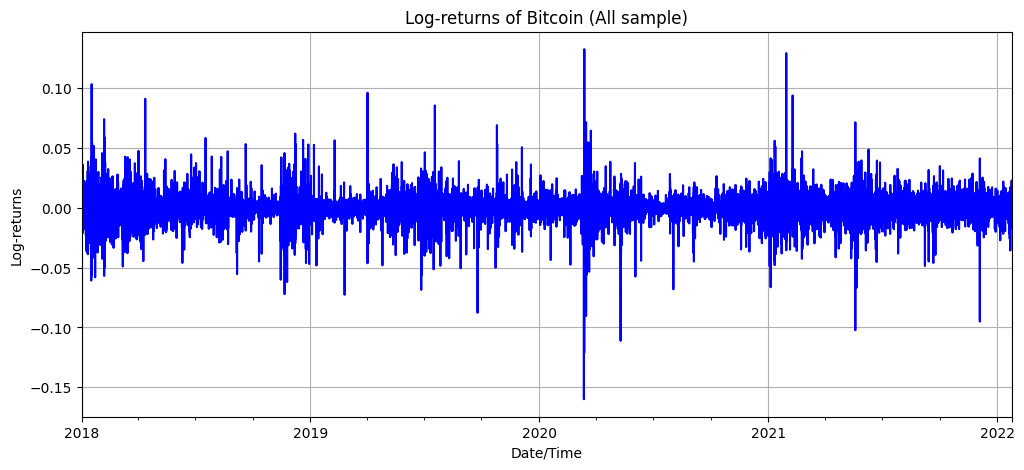

In [14]:
# Plotting log-returns
_ = df["LogReturns"].plot()
_ = plt.title("Log-returns of Bitcoin (All sample)")
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Log-returns")
_ = plt.grid()

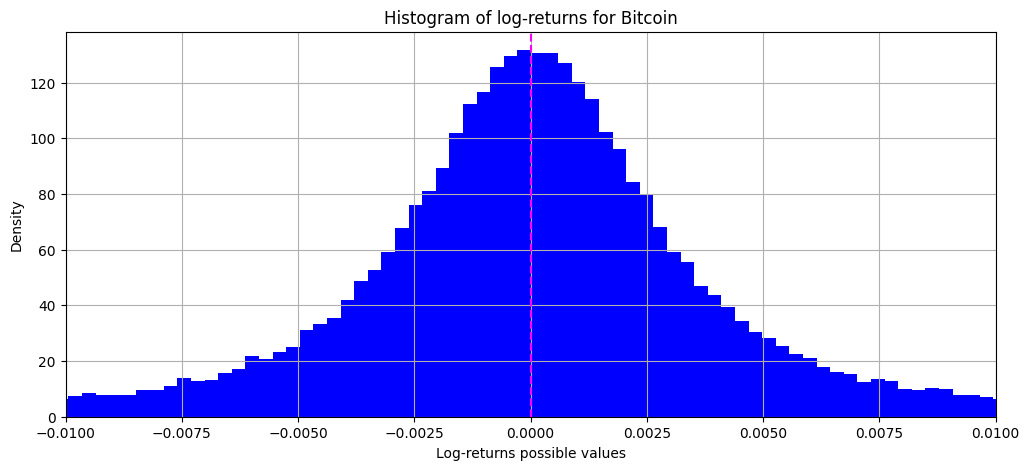

In [15]:
# Plotting log-returns
_ = df["LogReturns"].hist(bins=1000, density=True)
_ = plt.xlim([-0.01, 0.01])
_ = plt.title("Histogram of log-returns for Bitcoin")
_ = plt.xlabel("Log-returns possible values")
_ = plt.axvline(x = 0, color="magenta", ls="--")
_ = plt.ylabel("Density")

### Technical analysis indicators & Moving averages

In [16]:
# Computing Rolled average close price
df["Rolled_Avg_Close"] = df["Close"].rolling(window=10).mean()

# Computing correlation
df["Corr"] = df["Close"].rolling(window=10).corr(df["Rolled_Avg_Close"])

# Computing Open-Close indicator
df["Open-Close"] = df["Open"] - df["Close"].shift(1)

# Computing Open-Open indicator
df["Open-Open"] = df["Open"] - df["Open"].shift(1)

# Computing the RSI () indicator
df["RSI"] = Utils.rsi(df)

# Computing the Bollinger Bands (BB) indicators
upper_2sd, mid_2sd, lower_2sd = ta.BBANDS(df["Close"], 
                                          nbdevup=2,
                                          nbdevdn=2,
                                          timeperiod=20)
df["BBANDS_U"] = upper_2sd
df["BBANDS_M"] = mid_2sd
df["BBANDS_L"] = lower_2sd

# Computing SMA moving averages for various time windows
df["SMA_SLOW"] = ta.SMA(df["Close"], timeperiod=5)
df["SMA_MEDIUM"] = ta.SMA(df["Close"], timeperiod=10)
df["SMA_FAST"] = ta.SMA(df["Close"], timeperiod=15)

# TODO: Adding other technical analysis indicator
# Momentum
# Standard deviation
# ...

In [17]:
# Getting DataFrame shape
df_shape_before = df.shape[0]

# Dropping newly-created NaN values
df.dropna(inplace=True)

# Getting DataFrame shape
df_shape_after = df.shape[0]

# Getting number of deletedrows
abs(df_shape_after - df_shape_before)

19

In [18]:
# Displaying DataFrame
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,
2018-01-01 09:30:00,133.5,13573.258,13890.0,13461.00,13653.928,24.074755,13615.351313,1,0.005502,13671.0820,-0.036361,-5.748,46.350,51.418471,13866.561856,13601.4925,13336.423144,13631.4088,13671.0820,13629.223467
2018-01-01 10:00:00,140.5,13658.566,13954.6,13427.00,13597.016,17.076356,13609.079718,1,-0.004177,13670.3184,-0.200954,4.638,85.308,47.807548,13863.129370,13598.9293,13334.729230,13614.3792,13670.3184,13641.459733
2018-01-01 10:30:00,130.0,13596.980,13860.0,13479.04,13610.470,14.111266,13597.608882,1,0.000989,13675.9976,-0.612379,-0.036,-61.586,48.752857,13860.494642,13597.1271,13333.759558,13593.3220,13675.9976,13640.316933
2018-01-01 11:00:00,437.5,13623.206,13829.6,13023.80,13207.726,75.676137,13338.556003,1,-0.030037,13625.2082,-0.239578,12.736,26.226,30.424470,13890.033794,13576.9509,13263.868006,13529.6292,13625.2082,13621.032933
2018-01-01 11:30:00,228.0,13201.142,13499.0,13001.13,13299.240,48.695618,13258.765487,1,0.006905,13568.2598,0.556195,-6.584,-422.064,36.455838,13894.301029,13575.0653,13255.829571,13473.6760,13568.2598,13605.222267


### External data sources (e.g. Binance, Coinbase, FTX, ...)

$\longrightarrow$ Potential extension (10-min data of **S&P 500**, **DJIA**)

## Data pre-processing

In [19]:
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,
2018-01-01 09:30:00,133.5,13573.258,13890.0,13461.00,13653.928,24.074755,13615.351313,1,0.005502,13671.0820,-0.036361,-5.748,46.350,51.418471,13866.561856,13601.4925,13336.423144,13631.4088,13671.0820,13629.223467
2018-01-01 10:00:00,140.5,13658.566,13954.6,13427.00,13597.016,17.076356,13609.079718,1,-0.004177,13670.3184,-0.200954,4.638,85.308,47.807548,13863.129370,13598.9293,13334.729230,13614.3792,13670.3184,13641.459733
2018-01-01 10:30:00,130.0,13596.980,13860.0,13479.04,13610.470,14.111266,13597.608882,1,0.000989,13675.9976,-0.612379,-0.036,-61.586,48.752857,13860.494642,13597.1271,13333.759558,13593.3220,13675.9976,13640.316933
2018-01-01 11:00:00,437.5,13623.206,13829.6,13023.80,13207.726,75.676137,13338.556003,1,-0.030037,13625.2082,-0.239578,12.736,26.226,30.424470,13890.033794,13576.9509,13263.868006,13529.6292,13625.2082,13621.032933
2018-01-01 11:30:00,228.0,13201.142,13499.0,13001.13,13299.240,48.695618,13258.765487,1,0.006905,13568.2598,0.556195,-6.584,-422.064,36.455838,13894.301029,13575.0653,13255.829571,13473.6760,13568.2598,13605.222267


In [20]:
# Computation of the target
df["Target"] = np.where(df["Close"].shift(-1) > df["Close"], 1, 0)

In [21]:
correlation_matrix = df.corr()
df.corr().style.background_gradient(cmap='autumn')

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST,Target
Count,1.000000,0.589104,0.592232,0.584155,0.588751,0.595605,0.588731,-0.013513,-0.030555,0.590742,0.112084,0.047447,-0.084845,-0.043916,0.599355,0.591963,0.584111,0.589780,0.590742,0.591424,0.010159
Open,0.589104,1.000000,0.999964,0.999933,0.999961,-0.008439,0.999986,0.000372,-0.002751,0.999925,0.001520,0.020207,0.005108,0.013462,0.999636,0.999815,0.999667,0.999977,0.999925,0.999870,-0.002620
High,0.592232,0.999964,1.000000,0.999888,0.999966,-0.005488,0.999975,0.000314,0.000839,0.999906,0.001962,0.020876,0.004507,0.014448,0.999681,0.999805,0.999601,0.999955,0.999906,0.999856,-0.002707
Low,0.584155,0.999933,0.999888,1.000000,0.999945,-0.013015,0.999953,0.000326,0.001551,0.999841,0.000888,0.019741,0.006243,0.015814,0.999471,0.999715,0.999634,0.999910,0.999841,0.999777,-0.002897
Close,0.588751,0.999961,0.999966,0.999945,1.000000,-0.008790,0.999988,0.000321,0.003865,0.999897,0.001520,0.020373,0.004870,0.015915,0.999606,0.999784,0.999636,0.999955,0.999897,0.999840,-0.002955
Volume,0.595605,-0.008439,-0.005488,-0.013015,-0.008790,1.000000,-0.008758,-0.031810,-0.057463,-0.007439,0.194730,0.019614,-0.060402,-0.044425,-0.000340,-0.006692,-0.013268,-0.008023,-0.007439,-0.007017,0.013337
VWAP,0.588731,0.999986,0.999975,0.999953,0.999988,-0.008758,1.000000,0.000358,0.000758,0.999916,0.001520,0.020347,0.004937,0.014770,0.999625,0.999804,0.999657,0.999972,0.999916,0.999860,-0.002758
TimeRange,-0.013513,0.000372,0.000314,0.000326,0.000321,-0.031810,0.000358,1.000000,-0.005559,0.000363,-0.005548,-0.000241,-0.004611,0.027294,0.000486,0.000149,-0.000199,0.000404,0.000363,0.000246,-0.005960
LogReturns,-0.030555,-0.002751,0.000839,0.001551,0.003865,-0.057463,0.000758,-0.005559,1.000000,-0.001847,-0.000711,0.061207,-0.015458,0.361880,-0.002008,-0.002042,-0.002075,-0.001314,-0.001847,-0.001974,-0.056619
Rolled_Avg_Close,0.590742,0.999925,0.999906,0.999841,0.999897,-0.007439,0.999916,0.000363,-0.001847,1.000000,0.001629,0.019794,-0.001730,0.007622,0.999769,0.999942,0.999788,0.999969,1.000000,0.999980,-0.002288


In [22]:
# Select upper triangle of correlation matrix (because it's a symmetric matrix)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
#print(upper)

# Find features with correlation greater than a fixed threshold
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)

['High', 'Low', 'Close', 'VWAP', 'Rolled_Avg_Close', 'BBANDS_U', 'BBANDS_M', 'BBANDS_L', 'SMA_SLOW', 'SMA_MEDIUM', 'SMA_FAST']


In [23]:
# Drop highly correlated features
to_drop = ["Open", "High", "Low", "VWAP", "SMA_SLOW"] # "Rolled_Avg_Close", "BBANDS_U", "BBANDS_M", "BBANDS_L", "SMA_MEDIUM", "SMA_FAST"
"""
try:
    if len(to_drop) != 0:
        df.drop(to_drop, axis=1, inplace=True)
        print("Removing high-correlated columns")
except KeyError as e:
    print("High-correlated features already removed")
"""

'\ntry:\n    if len(to_drop) != 0:\n        df.drop(to_drop, axis=1, inplace=True)\n        print("Removing high-correlated columns")\nexcept KeyError as e:\n    print("High-correlated features already removed")\n'

In [24]:
# Outliers detection + removing (Winsorize methods)

In [25]:
# Confusion matrix + see report on + Intro ML Bologna

In [26]:
LAGGED_SERIES = list(range(1, 20))
for lag in LAGGED_SERIES:
    df[f"Close (t - {lag})"] = df["Close"].shift(periods=lag)
    #df[f"Target (t - {lag})"] = df["Target"].shift(periods=lag)
    df[f"RSI (t - {lag})"] = df["RSI"].shift(periods=lag)
# Dropping newly-created NaN values
df.dropna(inplace=True)

In [27]:
# Getting initial dataset (subset of time range)
btc_2018 = df["2018-01": "2018-04"]

In [28]:
btc_2018.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,...,Close (t - 15),RSI (t - 15),Close (t - 16),RSI (t - 16),Close (t - 17),RSI (t - 17),Close (t - 18),RSI (t - 18),Close (t - 19),RSI (t - 19)
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 19:00:00,191.5,13204.332,13680.0,13050.00,13265.314000,25.693697,13213.929654,3,0.004840,13230.501400,...,13299.240,36.455838,13207.726,30.424470,13610.470,48.752857,13597.016,47.807548,13653.928,51.418471
2018-01-01 19:30:00,191.5,13261.476,13659.0,13106.00,13338.313484,34.243510,13285.040174,3,0.005488,13238.374148,...,13201.835,33.065906,13299.240,36.455838,13207.726,30.424470,13610.470,48.752857,13597.016,47.807548
2018-01-01 20:00:00,335.5,13334.952,13850.0,13222.03,13444.426000,62.028854,13462.381286,3,0.007924,13243.878748,...,13260.444,36.983494,13201.835,33.065906,13299.240,36.455838,13207.726,30.424470,13610.470,48.752857
2018-01-01 20:30:00,227.0,13445.476,13690.0,13360.00,13463.250000,36.098837,13469.161641,3,0.001399,13259.462548,...,13134.420,32.446340,13260.444,36.983494,13201.835,33.065906,13299.240,36.455838,13207.726,30.424470
2018-01-01 21:00:00,288.0,13455.428,13800.0,13380.82,13634.156000,58.175487,13596.026066,4,0.012614,13308.954148,...,13100.922,31.311834,13134.420,32.446340,13260.444,36.983494,13201.835,33.065906,13299.240,36.455838


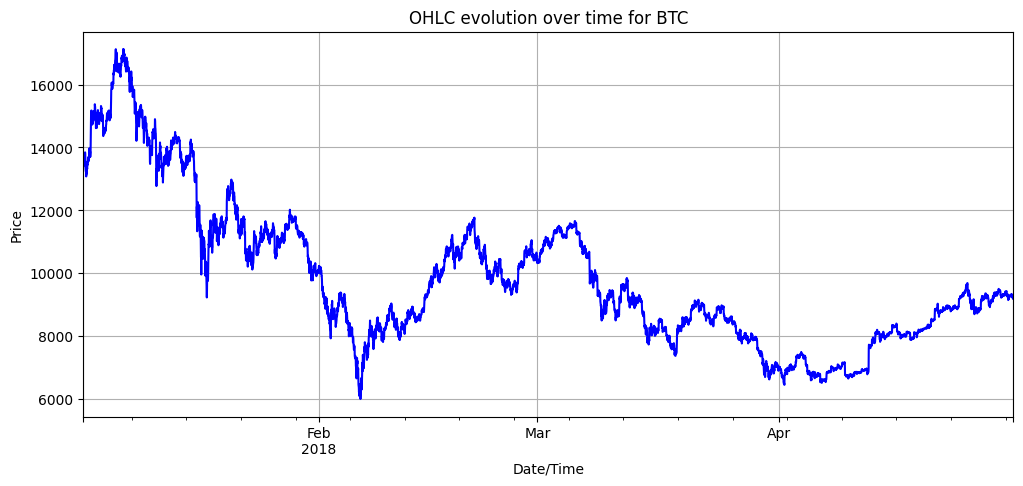

In [29]:
# Plotting OHLC time series
_ = btc_2018["Close"].plot()
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Price")
_ = plt.title("OHLC evolution over time for BTC")

In [30]:
# Getting DataFrame shape
nb_obs, nb_cols = btc_2018.shape
print(f"Number of 30-min bins:\t {nb_obs}\nNumber of columns:\t {nb_cols}")

Number of 30-min bins:	 5722
Number of columns:	 59


In [31]:
# Removing old model files
files = glob.glob("../out/models/model_*")
for f in files:
    os.remove(f)
print("Removing model files from previous fitting steps")

Removing model files from previous fitting steps


In [32]:
# Test on WF

# Splitting X/Y
X = btc_2018.copy() # X as a deep copy for security reason
Y = X.pop("Target")

# Defining the number of train points and number of records
n_train = 2_000
n_records = 2_400 #len(btc_2018)//2 # 200

# Declaring the main model # 0.1 for eta (or 0.03)
model = XGBClassifier(learning_rate=0.1, n_estimators=120, max_depth=4, max_leaves=3, objective='binary:logistic') #, booster='gbtree')

# Model name (on-disk storage)
MODEL_NAME = f"../out/models/model_{0}"

# Horizon lags
HORIZON_LAGS = {
    "future": 10, # 15
    "past": n_train - int(n_train*0.4) # None
}

# Metrics
METRICS = {
    "train_size": {}, # Shape of the train set
    "test_size": {}, # Shape of the test set
    "exec_time": {}, # Execution (fitting + prediction) time
    "model_size": {} # File size of the on-disk model
}

# Predictions dataframes
preds_cols = ["ts"] + [str(i) for i in range(1, HORIZON_LAGS["future"] + 1)] + ["conf_mat"] + ["report"]
preds = pd.DataFrame(columns=preds_cols)

# Looping over each time t
for k, i in enumerate((pbar := tqdm.tqdm_notebook(range(n_train, n_records), colour="red"))):
    #print(k, "--", i)
    
    # Train/test split for X
    X_train = X.iloc[i - HORIZON_LAGS["past"]: i] # X.iloc[0: i]
    X_test = X.iloc[i: i + HORIZON_LAGS["future"]]
    
    # Getting the current datetime
    dt_now = list(X_train.index)[-1]
    
    # Defining the scaler pre-processor
    scaler = MinMaxScaler() # StandardScaler()
    
    # Scaling X_train
    X_train_scaled = scaler.fit_transform(X_train)
    # - None: XGBoost model fitting with X_train_scaled & Y_train
    # - X_test_scaled: Scaling of X_test using this scaler with input as X_test
    # - Y_pred: XGBoost model prediction with input X_test_scaled
    
    # Saving lengths
    METRICS["train_size"][dt_now] = len(X_train)
    METRICS["test_size"][dt_now] = len(X_test)

    # Train/test split for Y
    Y_train = Y.iloc[i - HORIZON_LAGS["past"]: i] # Y.iloc[0: i]
    Y_test = Y.iloc[i: i + HORIZON_LAGS["future"]]
    
    # Timing the fitting & prediction operations
    start_time = time.time()
    
    # If first iteration, only fit
    if k == 0:
        model.fit(X=X_train, y=Y_train) # or X_train_scaled
    else:        
        # If next iterations, fitting using previous knowledge (saved on-disk)
        model.fit(X=X_train, y=Y_train, xgb_model=MODEL_NAME) # or X_train_scaled
    
    # Model name (on-disk storage) ==> Use the k-th counter to track iterations on MODEL_NAME to re-use fit
    MODEL_NAME = f"../out/models/model_{k}"
    
    # Saving the model for incremental learning (growing filtration)
    model.get_booster().save_model(MODEL_NAME)
    
    # Scaling the X_test dataset with the scaler trained on X_train
    X_test_scaled = scaler.transform(X_test)
    
    # Predicting the HORIZON_LAGS["future"] market movements from dt_now
    Y_pred = model.predict(X=X_test) # or X_test_scaled
    #print(Y_pred)
    
    if k == 0:
        METRICS["model_size"][dt_now] = 0.0
    else:
        METRICS["model_size"][dt_now] = os.path.getsize(MODEL_NAME)/1e6
    
    # Storing the duration time for fitting step
    dur_time = time.time() - start_time
    METRICS["exec_time"][dt_now] = dur_time
    #print(f"Exec. time: {dur_time:.3f}s")
    pbar.set_description(f"#{k} - Current time: {dt_now}\t\t | Exec. time: {dur_time:.3f}s | FITTING")

    # Computing the confusion matrix
    conf_mat = confusion_matrix(y_true=list(Y_test.values), y_pred=list(Y_pred))
    
    # Getting classification report
    clf_report = classification_report(y_true=Y_test, y_pred=Y_pred, output_dict=True)
    
    # Appending the predictions
    preds = preds.append(pd.DataFrame([[dt_now] + list(Y_pred) + [conf_mat] + [clf_report]], columns=preds_cols), ignore_index=True)
    
    #print(train.shape, test.shape)

# Setting the timestamp as index column
try:
    preds.set_index("ts", inplace=True)
except KeyError:
    pass

  0%|          | 0/400 [00:00<?, ?it/s]

**References**:
1. https://greyhoundanalytics.com/blog/backtestingpy-a-complete-quickstart-guide/
2. https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.plot
3. https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [34]:
# Broadcasting into a Pandas DataFrame
METRICS_ = pd.DataFrame(METRICS)

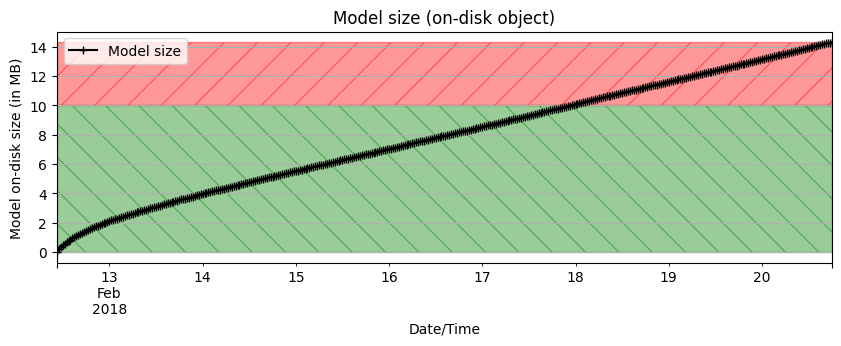

In [35]:
# Plotting model file size
_ = METRICS_["model_size"].plot(marker="+", label="Model size", figsize=(10, 3), color="black")
threshold_ = 10
_ = plt.axhspan(ymin=METRICS_["model_size"].min(), ymax=threshold_, color="green", hatch="\\", alpha=0.4)
_ = plt.axhspan(ymin=threshold_, ymax=METRICS_["model_size"].max(), color="red", hatch="/", alpha=0.4)
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Model on-disk size (in MB)")
_ = plt.title("Model size (on-disk object)")
_ = plt.legend()

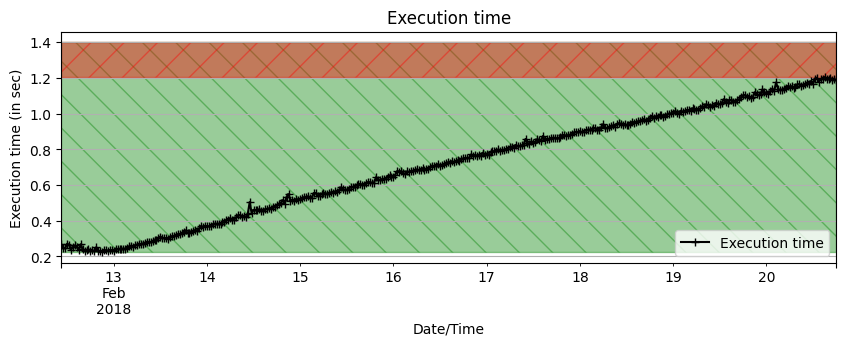

In [36]:
# Plotting exec. time for each fitting step
_ = METRICS_["exec_time"].plot(marker="+", label="Execution time", figsize=(10, 3), color="black")
threshold_ = 1.4
_ = plt.axhspan(ymin=METRICS_["exec_time"].min(), ymax=threshold_, color="green", hatch="\\", alpha=0.4)
_ = plt.axhspan(ymin=threshold_, ymax=METRICS_["exec_time"].max(), color="red", hatch="/", alpha=0.4)
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Execution time (in sec)")
_ = plt.title("Execution time")
_ = plt.legend()

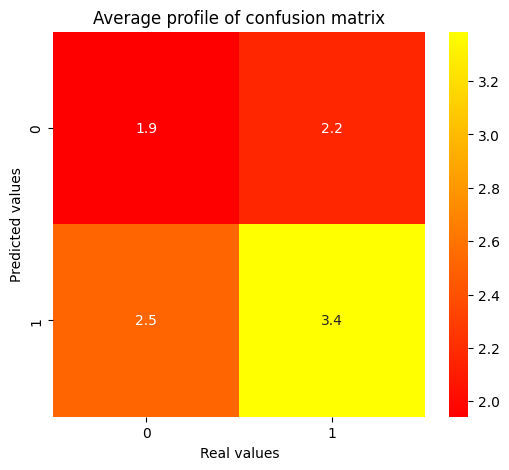

In [37]:
# Getting the 
_ = plt.figure(figsize=(6, 5))
_ = sns.heatmap(preds["conf_mat"].mean(), annot=True, cmap="autumn")
_ = plt.title("Average profile of confusion matrix")
_ = plt.xlabel("Real values")
_ = plt.ylabel("Predicted values")

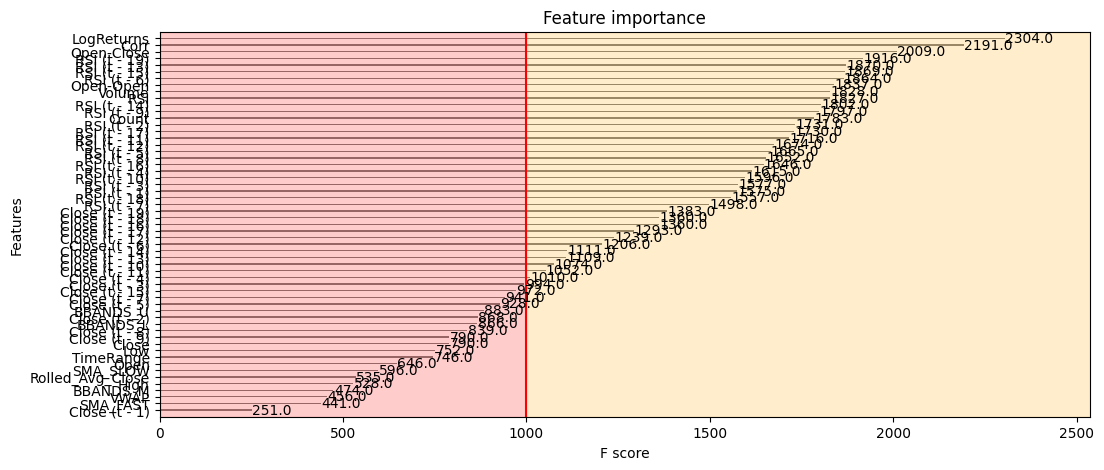

In [38]:
# Plot features 
_ = plot_importance(booster=model.get_booster(), grid=False, color="gray")
_ = plt.axvline(x = 1000, color="red")

# Adding region to "categorize" features importance
_ = plt.axvspan(xmin=0, xmax=1000, color="red", alpha=0.2)
_ = plt.axvspan(xmin=1000, xmax=4000, color="orange", alpha=0.2)
_ = plt.axvspan(xmin=4000, xmax=6000, color="yellow", alpha=0.2)
_ = plt.axvspan(xmin=6000, xmax=8000, color="green", alpha=0.2)

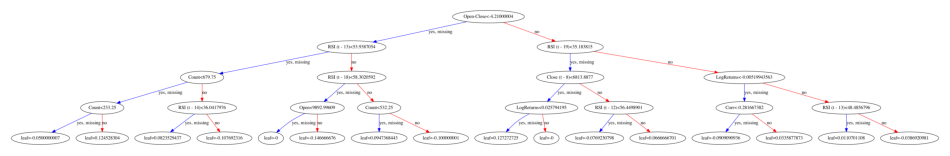

In [39]:
_ = plot_tree(booster=model.get_booster())

## Strategy

In [40]:
preds.head()

,1,2,3,4,5,6,7,8,9,10,conf_mat,report
ts,,,,,,,,,,,,
2018-02-12 10:30:00,0,0,0,0,0,0,1,0,0,0,"[[4, 1], [5, 0]]","{'0': {'precision': 0.4444444444444444, 'recal..."
2018-02-12 11:00:00,0,0,1,1,0,1,0,0,0,0,"[[2, 3], [5, 0]]","{'0': {'precision': 0.2857142857142857, 'recal..."
2018-02-12 11:30:00,0,1,1,0,1,0,1,0,1,0,"[[1, 4], [4, 1]]","{'0': {'precision': 0.2, 'recall': 0.2, 'f1-sc..."
2018-02-12 12:00:00,1,1,0,1,0,1,0,1,0,0,"[[1, 4], [4, 1]]","{'0': {'precision': 0.2, 'recall': 0.2, 'f1-sc..."
2018-02-12 12:30:00,1,0,1,0,1,0,0,0,0,0,"[[3, 2], [4, 1]]","{'0': {'precision': 0.42857142857142855, 'reca..."


In [41]:
s, e = Utils.get_preds_time_interval(preds).values()
s, e

(Timestamp('2018-02-12 10:30:00'), Timestamp('2018-02-20 18:00:00'))

In [42]:
data = btc_2018.loc[s:e]
data.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,...,Close (t - 15),RSI (t - 15),Close (t - 16),RSI (t - 16),Close (t - 17),RSI (t - 17),Close (t - 18),RSI (t - 18),Close (t - 19),RSI (t - 19)
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-02-12 10:30:00,498.0,8752.150000,8860.00,8720.00,8825.886667,132.574292,8810.226757,1,0.008474,8642.500833,...,8465.620000,62.807620,8528.306667,69.089475,8394.950000,61.768291,8344.363333,58.404869,8339.068333,58.057264
2018-02-12 11:00:00,351.5,8827.676667,8848.00,8650.00,8699.945000,105.499015,8783.199272,1,-0.014372,8669.756667,...,8478.246667,63.549361,8465.620000,62.807620,8528.306667,69.089475,8394.950000,61.768291,8344.363333,58.404869
2018-02-12 11:30:00,500.5,8698.453333,8751.30,8621.00,8654.796667,111.627777,8684.485234,1,-0.005203,8693.263000,...,8464.385000,62.040132,8478.246667,63.549361,8465.620000,62.807620,8528.306667,69.089475,8394.950000,61.768291
2018-02-12 12:00:00,386.5,8653.688333,8751.30,8640.00,8710.698333,96.140713,8698.810141,1,0.006438,8712.514333,...,8492.353333,63.959018,8464.385000,62.040132,8478.246667,63.549361,8465.620000,62.807620,8528.306667,69.089475
2018-02-12 12:30:00,451.5,8710.960000,8799.99,8681.99,8766.355000,91.940490,8741.639733,1,0.006369,8742.206333,...,8418.770000,55.724453,8492.353333,63.959018,8464.385000,62.040132,8478.246667,63.549361,8465.620000,62.807620


In [43]:
# Defining the backtest object
bt = BT(data=data,                  # OHLCV dataset (Pandas DataFrame)
        predictions_=preds,         # Predicitions (Pandas DataFrame)
        strategy=Custom,            # Strategy (Class, not instance)
        cash=100_000,               # Initial cash
        commission=.0002,           # Commission
        margin=0.9,                 # Margin
        trade_on_close=True,        # Consider trading operations on close price of each bar ONLY
        hedging=False,              # FIFO manner
        exclusive_orders=True       # Auto-close of each order to initiate a new one
       )

Initializing the backtest instance ...


**Reference**:
- Documentation: https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.run

**Parameters**:
- **`data`**: `pd.DataFrame` with columns: Open, High, Low, Close, and (optionally) Volume
- **`predictions`**: `pd.DataFrame` with predictions for each datetime
- **`strategy`**: Strategy object (no instance)
- **`cash`**: initial cash to start with
- **`commission`**: the commission ratio. 

> E.g. if your broker's commission is 1% of trade value, set commission to 0.01. Note, if you wish to account for bid-ask spread, you can approximate doing so by increasing the commission, e.g. set it to 0.0002 for commission-less forex trading where the average spread is roughly 0.2‰ of asking price.

- **`margin`**: required margin (ratio) of a leveraged account. 

> No difference is made between initial and maintenance margins. To run the backtest using e.g. 50:1 leverge that your broker allows, set margin to 0.02 ($\frac{1}{\text{leverage}}$).
- **`trade_on_close`**: if `True`, market orders will be filled with respect to the current bar's closing price instead of the next bar's open.
- **`hedging`**: if `True`, allow trades in both directions simultaneously. If False, the opposite-facing orders first close existing trades in a **FIFO** manner.
- **`exclusive_orders`**: if `True`, each new order auto-closes the previous trade/position, making at most a single trade (long or short) in effect at each time.

In [44]:
# Running the backtesting operation
stats = bt.run()

Running the backtest procedure ...


In [45]:
# Defining the current timestamp (string representation)
dt_now = datetime.datetime.now().strftime("%m-%d-%Y_%H-%M-%S")

# Plotting the results curves (in the Jupyter notebook)
_ = bt.plot()

# Saving on-disk the results curves as HTML page
#_ = bt.plot(filename=f"../out/backtests/plots/plots_{dt_now}")

# Collecting statistical output from backtest
bt_results = stats

In [46]:
# Getting the statistical output from backtest (broadcasting into a Python dict from a BT stat type)
bt_results_ = {k:v for k, v in bt_results.items() if k not in ["_trades", "_equity_curve", "_strategy"]}

# Getting the output strategy instance
bt_strategy = bt_results["_strategy"]

# Getting the equity curve
bt_equity_curve = bt_results["_equity_curve"]

# Getting the trades table
bt_trades = bt_results["_trades"]

In [47]:
# Saving on-disk 
bt_trades.to_csv(f"../out/backtests/trades/trades_{dt_now}.csv")
bt_equity_curve.to_csv(f"../out/backtests/equity_curves/ec_{dt_now}.csv")

In [48]:
# Results from backtest
bt_results_

{'Start': Timestamp('2018-02-12 10:30:00'),
 'End': Timestamp('2018-02-20 18:00:00'),
 'Duration': Timedelta('8 days 07:30:00'),
 'Exposure Time [%]': 85.75,
 'Equity Final [$]': 113246.75018306675,
 'Equity Peak [$]': 114139.02400419452,
 'Return [%]': 13.246750183066746,
 'Buy & Hold Return [%]': 32.23944260935446,
 'Return (Ann.) [%]': 5543.015193113303,
 'Volatility (Ann.) [%]': 6819.12797811987,
 'Sharpe Ratio': 0.8128627605903345,
 'Sortino Ratio': 94.21751210159975,
 'Calmar Ratio': 525.0565632586956,
 'Max. Drawdown [%]': -10.556986772456089,
 'Avg. Drawdown [%]': -3.4335963038042094,
 'Max. Drawdown Duration': Timedelta('2 days 16:00:00'),
 'Avg. Drawdown Duration': Timedelta('0 days 16:17:00'),
 '# Trades': 207,
 'Win Rate [%]': 58.93719806763285,
 'Best Trade [%]': 3.313979836613856,
 'Worst Trade [%]': -3.038891275792799,
 'Avg. Trade [%]': 0.0578495045356231,
 'Max. Trade Duration': Timedelta('0 days 10:30:00'),
 'Avg. Trade Duration': Timedelta('0 days 00:49:00'),
 'Profi

In [49]:
# Number of trades
bt_trades.shape[0]

207

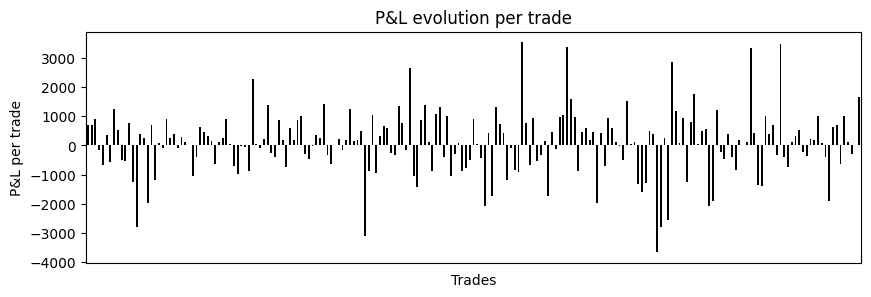

In [50]:
_ = bt_trades["PnL"].plot.bar(color="black", figsize=(10, 3), rot=40)
_ = plt.title("P&L evolution per trade")
_ = plt.xlabel("Trades")
_ = plt.ylabel("P&L per trade")
_ = plt.xticks([], [])
#_ = plt.grid()
#_ = plt.axhline(y = 0, color="red", alpha=0.2)

In [51]:
# Construction of time distribution of the trades (as a Gantt chart)
gantt = bt_trades[["EntryTime", "Duration"]]

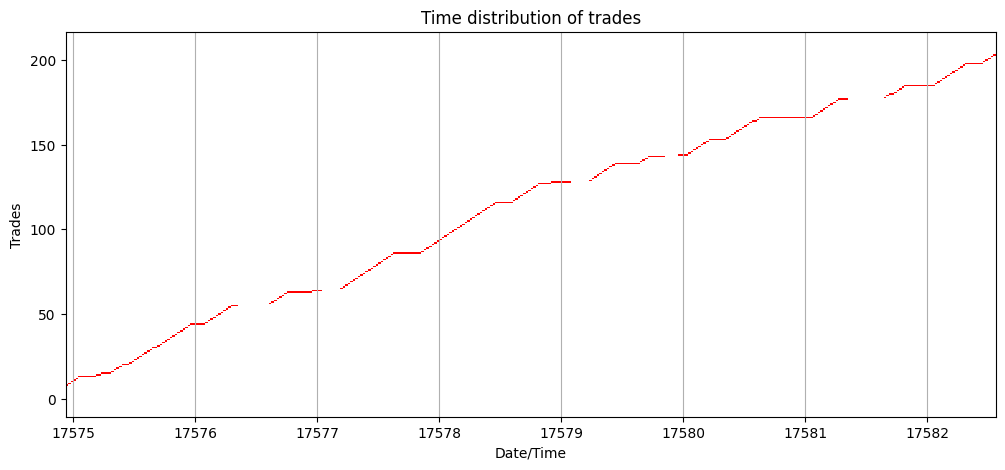

In [52]:
# Plotting the time distribution of the trades
_ = plt.barh(gantt.index, gantt["Duration"], left=gantt["EntryTime"], color="red")
_ = plt.title("Time distribution of trades")
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Trades")
_ = plt.grid(axis="x")